# Data Prep

In [ ]:
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 1.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
from google.colab import drive #type: ignore
drive.mount('/content/drive') # for google colab to access google drive
import pandas as pd
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.preprocessing import LabelEncoder
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import json

# Load our data paths
data_full_path = '/content/drive/My Drive/Colab Notebooks/Independent Study/Data/kddcup.data.gz'
test_path = '/content/drive/My Drive/Colab Notebooks/Independent Study/Data/corrected.gz'
names_path = '/content/drive/My Drive/Colab Notebooks/Independent Study/Data/kddcup.names'

Mounted at /content/drive


In [ ]:
# Build our dataframe
data = pd.read_csv(data_full_path, compression='gzip', header=None)
testset = pd.read_csv(test_path, compression='gzip', header=None)
names = pd.read_csv(names_path, skiprows=1, header=None, sep=':')
data.columns = names.iloc[:,0].tolist() + ['label']
testset.columns = names.iloc[:,0].tolist() + ['label']
data['label'] = data['label'].apply(lambda x: 'normal' if x == 'normal.' else 'anomaly')
testset['label'] = testset['label'].apply(lambda x: 'normal' if x == 'normal.' else 'anomaly')
og_shape = data.shape
print("Original Data Shape: ", data.shape)
print("Original Data Head: ", data.head(1))

# declare our categorical values
categorical_one = ['protocol_type', 'service', 'flag']
categorical_two = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_guest_login', 'is_host_login']
cat_all = categorical_one + categorical_two
categorical_vars = cat_all
print("Categorical Columns Declared: ",categorical_vars)

data = data.drop_duplicates()
#testset = testset.drop_duplicates()
new_shape = data.shape
print("Duplicates Dropped: ", og_shape[0] - new_shape[0])
print("New Data Shape: ", new_shape)
constant_columns = [col for col in data.columns if data[col].nunique() == 1]
print("Constant Columns: ", constant_columns)
#if any of the categotical variables are found in constant_columns, remove from categorical_vars
for col in constant_columns:
    if col in categorical_vars:
        categorical_vars.remove(col)

data = data.drop(columns=constant_columns)
testset = testset.drop(columns=constant_columns)
print("Columns Dropped: ", len(constant_columns))
print("New Categorical Columns: ", categorical_vars)
print("New Data Shape: ", data.shape)
print("New Test Set Shape: ", testset.shape)

X_train = data.drop(columns=['label'])
X_test = testset.drop(columns=['label'])
y_train = data['label']
y_test = testset['label']

print('\n\n\n')
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

Original Data Shape:  (4898431, 42)
Original Data Head:     duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        215      45076     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   0   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     0.0                     0.0   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                          0.0                          0.0   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                   0.0   

   dst_host_srv_rerror_rate   label  
0                       0.0  normal  

[1 rows x 42 columns]
Categorical Columns Declared:  ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'root_shell', 'su_attempted', 'is_guest_login', 'is_host_login']
Duplicates Dropped:  3823448
New Data Shape: 

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1074983 entries, 0 to 4898430
Data columns (total 41 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   duration                     1074983 non-null  int64  
 1   protocol_type                1074983 non-null  object 
 2   service                      1074983 non-null  object 
 3   flag                         1074983 non-null  object 
 4   src_bytes                    1074983 non-null  int64  
 5   dst_bytes                    1074983 non-null  int64  
 6   land                         1074983 non-null  int64  
 7   wrong_fragment               1074983 non-null  int64  
 8   urgent                       1074983 non-null  int64  
 9   hot                          1074983 non-null  int64  
 10  num_failed_logins            1074983 non-null  int64  
 11  logged_in                    1074983 non-null  int64  
 12  num_compromised              1074983 non-null  

In [ ]:
#see label distributopn for y_train
print(y_test.value_counts())

label
anomaly    250436
normal      60593
Name: count, dtype: int64


In [ ]:
# prompt: We need to see the ratio of target variables in the test set

# Calculate the ratio of target variables in the test set
target_ratio = y_test.value_counts(normalize=True)
print("Ratio of target variables in the test set:\n", target_ratio)


Ratio of target variables in the test set:
 label
anomaly    0.805185
normal     0.194815
Name: proportion, dtype: float64


In [ ]:
#see label distributopn for y_train
print(y_train.value_counts())

label
normal     812814
anomaly    262169
Name: count, dtype: int64


# Generate Embeddings

Embeddings without numeric text encoding

In [ ]:
embeddings_train = X_train.copy()
embeddings_test = X_test.copy()
#these columns we convert to boolean
columns_to_check = categorical_two
for col in columns_to_check:
  embeddings_train[col] = embeddings_train[col].astype(bool)
  embeddings_test[col] = embeddings_test[col].astype(bool)
def textualize(X_train, X_test, y_train=None, add_label=False):
    # Helper function to convert a data row to textual format
    def to_textual(data, labels=None):
        textual_data = []
        for index, row in enumerate(data.values):
            row_textual = [f"{col}: {val}" for col, val in zip(data.columns, row)]
            if add_label and labels is not None:
                row_textual.append(f"label: {labels.iloc[index]}")
            textual_data.append(' '.join(row_textual))
        return textual_data

    train_x_textual = to_textual(X_train, y_train if add_label else None)
    test_x_textual = to_textual(X_test)  # Labels typically not needed for test data in description generation

    return train_x_textual, test_x_textual

train_textual, test_textual = textualize(embeddings_train, embeddings_test)
print(train_textual[0])
print(test_textual[0])
print(len(train_textual), y_train.shape)
print(len(test_textual), y_test.shape)

duration: 0 protocol_type: tcp service: http flag: SF src_bytes: 215 dst_bytes: 45076 land: False wrong_fragment: 0 urgent: 0 hot: 0 num_failed_logins: 0 logged_in: True num_compromised: 0 root_shell: False su_attempted: False num_root: 0 num_file_creations: 0 num_shells: 0 num_access_files: 0 is_host_login: False is_guest_login: False count: 1 srv_count: 1 serror_rate: 0.0 srv_serror_rate: 0.0 rerror_rate: 0.0 srv_rerror_rate: 0.0 same_srv_rate: 1.0 diff_srv_rate: 0.0 srv_diff_host_rate: 0.0 dst_host_count: 0 dst_host_srv_count: 0 dst_host_same_srv_rate: 0.0 dst_host_diff_srv_rate: 0.0 dst_host_same_src_port_rate: 0.0 dst_host_srv_diff_host_rate: 0.0 dst_host_serror_rate: 0.0 dst_host_srv_serror_rate: 0.0 dst_host_rerror_rate: 0.0 dst_host_srv_rerror_rate: 0.0
duration: 0 protocol_type: udp service: private flag: SF src_bytes: 105 dst_bytes: 146 land: False wrong_fragment: 0 urgent: 0 hot: 0 num_failed_logins: 0 logged_in: False num_compromised: 0 root_shell: False su_attempted: False

X

In [ ]:
def embed_data(train_text, test_text):
    # embed data with LLM
    llm_model = SentenceTransformer(r"sentence-transformers/paraphrase-MiniLM-L6-v2")
    embeddings_train = llm_model.encode(train_text, show_progress_bar=True, normalize_embeddings=True)
    embeddings_test = llm_model.encode(test_text, show_progress_bar=True, normalize_embeddings=True)
    return embeddings_train, embeddings_test
embeddings_train, embeddings_test = embed_data(train_textual, test_textual)
print(embeddings_train.shape)
print(embeddings_test.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/33594 [00:00<?, ?it/s]

Batches:   0%|          | 0/9720 [00:00<?, ?it/s]

(1074983, 384)
(311029, 384)


differest embedding model, bge model

In [ ]:
import torch
from sentence_transformers import SentenceTransformer

def embed_data(train_text, test_text):
    # embed data with LLM and ensure CUDA usage
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    llm_model = SentenceTransformer(r"BAAI/bge-large-en-v1.5")

    # Move the model to the appropriate device (GPU if available)
    llm_model = llm_model.to(device)

    # Perform embedding on the appropriate device
    embeddings_train = llm_model.encode(train_text,
                                        show_progress_bar=True,
                                        normalize_embeddings=True,
                                        device=device)

    embeddings_test = llm_model.encode(test_text,
                                       show_progress_bar=True,
                                       normalize_embeddings=True,
                                       device=device)

    return embeddings_train, embeddings_test

embeddings_train, embeddings_test = embed_data(train_textual, test_textual)
print(embeddings_train.shape)
print(embeddings_test.shape)


model.safetensors:  14%|#4        | 189M/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [ ]:
import re

def process_all_numbers(text):
    def f(match):
        num = match.group(0)
        integer_part = match.group(1)
        integer_length = len(integer_part)
        decimal_part = match.group(3)
        decimal_length = len(decimal_part) if decimal_part else 0

        if decimal_part:
            prefix = f'<sn>{integer_length}.{decimal_length}<mn>'
        else:
            prefix = f'<sn>{integer_length}<mn>'

        return prefix + num + '<en>'

    pattern = r'(\d+)(\.(\d+))?'
    return re.sub(pattern, f, text)



train_processed_text = []
test_processed_text = []

for string in train_textual:
    processed_string = process_all_numbers(string)
    train_processed_text.append(processed_string)

for string in test_textual:
    processed_string = process_all_numbers(string)
    test_processed_text.append(processed_string)


print("Before Process:")
print(train_textual[0])



print("\nPost-Processed String:")
print(train_processed_text[0])

def embed_data(train_text, test_text):
    # embed data with LLM
    llm_model = SentenceTransformer(r"sentence-transformers/paraphrase-MiniLM-L6-v2")
    embeddings_train = llm_model.encode(train_text, show_progress_bar=True, normalize_embeddings=True)
    embeddings_test = llm_model.encode(test_text, show_progress_bar=True, normalize_embeddings=True)
    return embeddings_train, embeddings_test

embeddings_train, embeddings_test = embed_data(train_processed_text, test_processed_text)
print(embeddings_train.shape)
print(embeddings_test.shape)

Before Process:
duration: 0 protocol_type: tcp service: http flag: SF src_bytes: 215 dst_bytes: 45076 land: False wrong_fragment: 0 urgent: 0 hot: 0 num_failed_logins: 0 logged_in: True num_compromised: 0 root_shell: False su_attempted: False num_root: 0 num_file_creations: 0 num_shells: 0 num_access_files: 0 is_host_login: False is_guest_login: False count: 1 srv_count: 1 serror_rate: 0.0 srv_serror_rate: 0.0 rerror_rate: 0.0 srv_rerror_rate: 0.0 same_srv_rate: 1.0 diff_srv_rate: 0.0 srv_diff_host_rate: 0.0 dst_host_count: 0 dst_host_srv_count: 0 dst_host_same_srv_rate: 0.0 dst_host_diff_srv_rate: 0.0 dst_host_same_src_port_rate: 0.0 dst_host_srv_diff_host_rate: 0.0 dst_host_serror_rate: 0.0 dst_host_srv_serror_rate: 0.0 dst_host_rerror_rate: 0.0 dst_host_srv_rerror_rate: 0.0

Post-Processed String:
duration: <sn>1<mn>0<en> protocol_type: tcp service: http flag: SF src_bytes: <sn>3<mn>215<en> dst_bytes: <sn>5<mn>45076<en> land: False wrong_fragment: <sn>1<mn>0<en> urgent: <sn>1<mn>0<e

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/33594 [00:00<?, ?it/s]

Batches:   0%|          | 0/9720 [00:00<?, ?it/s]

(1074983, 384)
(311029, 384)


In [ ]:
# prompt: save and download our train and test embeddings

import numpy as np

np.save('/content/drive/My Drive/Colab Notebooks/Independent Study/Data/embeddings_train.npy', embeddings_train)
np.save('/content/drive/My Drive/Colab Notebooks/Independent Study/Data/embeddings_test.npy', embeddings_test)

from google.colab import files

files.download('/content/drive/My Drive/Colab Notebooks/Independent Study/Data/embeddings_train.npy')
files.download('/content/drive/My Drive/Colab Notebooks/Independent Study/Data/embeddings_test.npy')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# prompt: load the embeddings from wh. make sure to remount driveere they were saved


embeddings_train = np.load('/content/drive/My Drive/Colab Notebooks/Independent Study/Data/embeddings_train.npy')
embeddings_test = np.load('/content/drive/My Drive/Colab Notebooks/Independent Study/Data/embeddings_test.npy')

print(embeddings_train.shape)
print(embeddings_test.shape)


(1074983, 384)
(311029, 384)


In [ ]:
from sklearn.decomposition import PCA

def apply_pca(X_train, X_test, variance_threshold=0.95):
    # Fit PCA on training data
    pca = PCA(n_components=variance_threshold, svd_solver='full')
    pca.fit(X_train)

    # Transform both train and test data
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    n_components = pca.n_components_
    print(f"Number of components selected: {n_components}")
    print(f"Cumulative explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

    return X_train_pca, X_test_pca, n_components

# Apply PCA to embeddings
embeddings_train_pca, embeddings_test_pca, n_components = apply_pca(embeddings_train, embeddings_test)

print(embeddings_train_pca.shape)
print(embeddings_test_pca.shape)
print(f"Number of components selected: {n_components}")

Number of components selected: 39
Cumulative explained variance ratio: 0.9514
(1074983, 39)
(311029, 39)
Number of components selected: 39


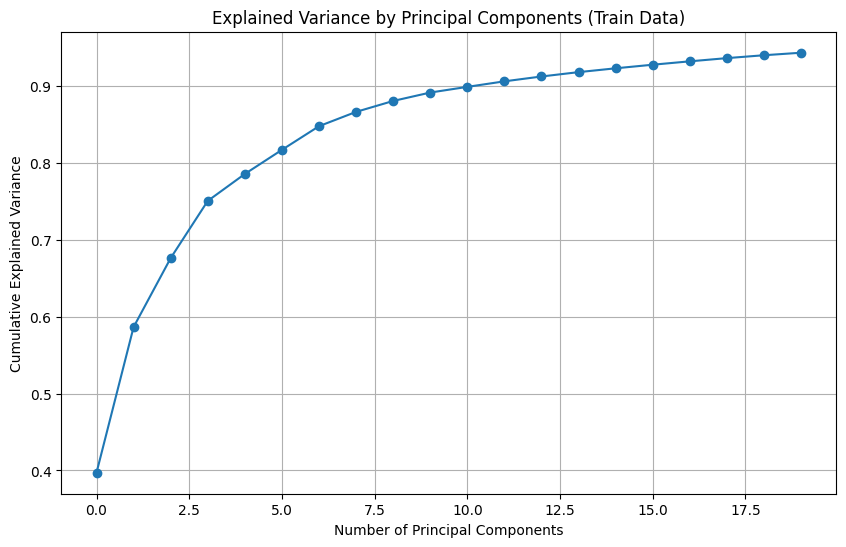

Top features for each principal component (Train Data):
    PC1  PC2  PC3  PC4  PC5  PC6  PC7  PC8  PC9  PC10  PC11  PC12  PC13  PC14  \
0  250  202  224  231  222  372  246  224  103   356    55   285   281   315   
1  327  379  302  337  196   95   40   99  132   236   354   118    44   118   
2  371   41   97  209  269   43  316  149  358   118   229   357   286   176   
3  284  132  248  238   29   61  209  207  263   249     1   300     0   122   
4  204  219  179  289  123  102  102  361  205   211    72   126    82   327   
5  105  114  245  263  192  137  300  285  126    50   311    31   180   134   
6  376  199  222  370  117  151  314  310  163    20   173    11     9    91   
7  138  173   13  216  141  300  116  357  225   100   180   275   108   161   
8  272  177   11  150  171   99   32  277  255   188   300   313   365   252   
9  315  308   35  378  250   81  349  278  182   261   123    10   183   140   

   PC15  PC16  PC17  PC18  PC19  PC20  
0   181   298    97   

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 2: Apply PCA on the training data
pca = PCA(n_components=20)  # Adjust the number of components or the variance ratio
principal_components_train = pca.fit_transform(embeddings_train)
X_train_pca = principal_components_train

# Step 3: Analyze explained variance for the training data
explained_variance_train = pca.explained_variance_ratio_
cumulative_variance_train = np.cumsum(explained_variance_train)

# Plot the explained variance for the training data
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_train, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components (Train Data)')
plt.grid()
plt.show()

# Step 4: Analyze loading scores for the training data
loading_scores_train = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(pca.components_))])
top_features_train = loading_scores_train.apply(lambda x: np.abs(x).nlargest(10).index, axis=0)  # Top 10 features for each PC

print("Top features for each principal component (Train Data):\n", top_features_train)


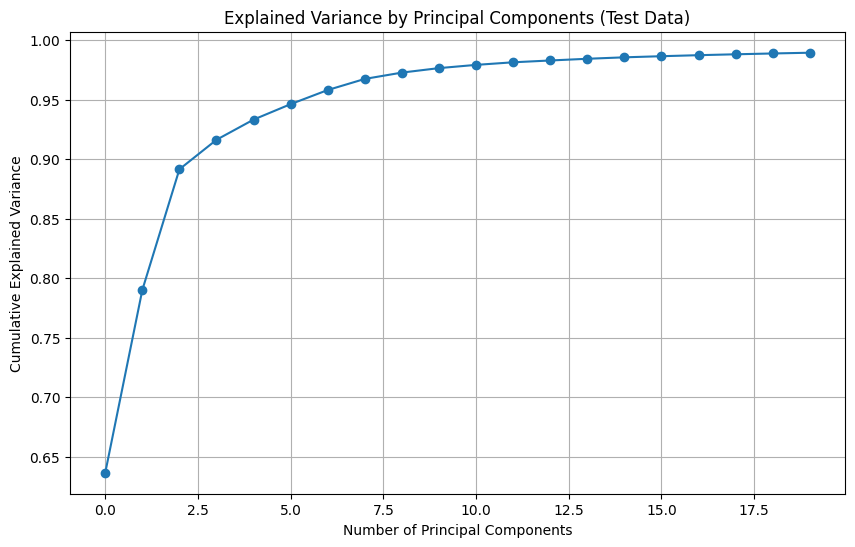

Top features for each principal component (Test Data):
    PC1  PC2  PC3  PC4  PC5  PC6  PC7  PC8  PC9  PC10  PC11  PC12  PC13  PC14  \
0   32  250  192  211  248  137  356  245  354   207   303   267   249   122   
1  250  327  278   95  179  263  149  300  204   247   372   182   319   181   
2  166  197  269   99  302  224  126   40  275   152   145   132   100    20   
3  379  379  371  158  282  361  224  285  364   305    16    89   358   191   
4  196  120  222  150  224   97  236  370  286   229   301   173   261   174   
5  102  331  215  238   35   99  300  383  229    90   357    55   223   153   
6  373  308   94  271   96  380   91  373  218   313   102   215   153   311   
7   75  115  102  259  144  141  258  314  259   337   237   205   118   255   
8  202  245  171  337  183  226  141  246   53   291   190   103    20    41   
9  194   26  188  201   11  316  158  231  140   287   247   209   376   137   

   PC15  PC16  PC17  PC18  PC19  PC20  
0   313   183   364   2

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 2: Apply PCA on the training data
pca = PCA(n_components=20)  # Adjust the number of components or the variance ratio
principal_components_test = pca.fit_transform(embeddings_test)
X_test_pca = principal_components_test

# Step 3: Analyze explained variance for the training data
explained_variance_test = pca.explained_variance_ratio_
cumulative_variance_test = np.cumsum(explained_variance_test)

# Plot the explained variance for the training data
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_test, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components (Test Data)')
plt.grid()
plt.show()

# Step 4: Analyze loading scores for the training data
loading_scores_test = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(pca.components_))])
top_features_test = loading_scores_test.apply(lambda x: np.abs(x).nlargest(10).index, axis=0)  # Top 10 features for each PC

print("Top features for each principal component (Test Data):\n", top_features_test)


Embeddings with Numeric Encoding

# ML Preprocessing

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

def label_encode(X_train, X_test):
    # Label encode categorical variables
    le = LabelEncoder()
    for col in X_train.columns:
        if col in categorical_vars:
            X_train[col] = le.fit_transform(X_train[col])
            X_test[col] = le.fit_transform(X_test[col])
    return X_train, X_test

def one_hot_encode(X_train, X_test, categorical_vars):
    # One-hot encode categorical variables
    X_train = pd.get_dummies(X_train, columns=categorical_vars).astype(int)
    X_test = pd.get_dummies(X_test, columns=categorical_vars).astype(int)

    # Align the columns of the test set to match the train set
    # Add any new columns in the test set to the train set with values of 0
    for col in X_test.columns:
        if col not in X_train.columns:
            X_train[col] = 0

    # Reindex the test set columns to match the train set columns
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    return X_train, X_test


# make numeric_cols the rest of the columns that dont appear in categorical_vars
numeric_cols = [col for col in X_train.columns if col not in categorical_vars]
print("Numeric Columns: ", numeric_cols)
def standardize(X_train, X_test):
    # Standardize numerical variables
    scaler = MinMaxScaler()
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
    return X_train, X_test


def apply_pca(X_train, X_test, variance_threshold=0.95):
    pca = PCA()
    pca.fit(X_train)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.where(cumsum >= variance_threshold)[0][0] + 1
    pca = PCA(n_components=20)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, n_components

X_train_ml, X_test_ml = one_hot_encode(X_train, X_test, categorical_one)
X_train_ml, X_test_ml = standardize(X_train_ml, X_test_ml)

#X_train_ml, X_test_ml, chosen_components = apply_pca(X_train_ml, X_test_ml)
#print(f"Number of PCA components chosen: {chosen_components}")

y_train_ml = y_train.map({'normal': 0, 'anomaly': 1})
y_test_ml = y_test.map({'normal': 0, 'anomaly': 1})

print(X_train_ml.shape)
print(X_test_ml.shape)
print(y_train_ml.shape)
print(y_test_ml.shape)


Numeric Columns:  ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
(1074983, 122)
(311029, 122)
(1074983,)
(311029,)


In [ ]:
#print distribution of y train and y test
print(y_train_ml.value_counts())
print(y_test_ml.value_counts())

label
0    812814
1    262169
Name: count, dtype: int64
label
1    250436
0     60593
Name: count, dtype: int64


In [ ]:
!pip install tqdm

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns #for plots
#our models and ML tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm  # Import tqdm for notebook usage

rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
etc = ExtraTreesClassifier()
svc = SVC()
knn = KNeighborsClassifier()
lr = LogisticRegression()

models = [rfc, abc, gbc, etc, lr, knn]
model_names = ['Random Forest', 'AdaBoost', 'Gradient Boost', 'Extra Trees', 'Logistic Regression', 'KNN']

def predicting_anomaly(X_train, X_test, y_train, y_test, models, names): #define prediction function
  display(HTML('<h1>Predicting Anomaly</h1>')) #display HTML

  def training(model, name, axes): #define training function
    model.fit(X_train, y_train) #fit the model
    pred = model.predict(X_test) #predict the values
    score = accuracy_score(y_test, pred) #obtain score
    report = classification_report(y_test, pred) #obtain report
    cm = confusion_matrix(y_test, pred) #obtain CM
    sns.heatmap(cm, annot=True, ax=axes) #optain heatmap
    axes.set_title("{}: {}%".format(name, round(score*100, 2))) #display formatting
    return score*100, report #returned results

  display(HTML('<h1>Training and evaluation of Network Traffic Binary Prediction</h1>')) #display HTML

  #create plots
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,7)) #create plots
  index = 0
  scores, reports = [], dict()
  for i in tqdm(range(2), desc="Row Progress"):
        for j in tqdm(range(3), desc="Column Progress", leave=False):
            print("Current Model: ", names[index])
            score, report = training(models[index], names[index], axes[i][j])
            reports[names[index]] = report
            index += 1
            scores += [score]
  plt.tight_layout()
  plt.show()

  dt = pd.DataFrame({"scores": scores}, index=names)
  dt = dt.sort_values("scores", ascending=False)
  dt["scores"] = round(dt["scores"], 2)
  fig, axes = plt.subplots()
  sns.barplot(x=dt.index, y=dt.iloc[:, 0], ax=axes)
  for container in axes.containers:
      axes.bar_label(container)
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
  axes.set_xlabel("Model Names")
  axes.set_title("Model Accuracy")
  plt.show()

  for i in dt.index:
        print("*"*30)
        print(i)
        print(reports[i])
        print("\n\n")

*This is only for seeing the 384 embedding tests with LG and KNN since we weere missing those results

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.notebook import tqdm

def predicting_anomaly_lr_knn(X_train, X_test, y_train, y_test):
    display(HTML('<h1>Predicting Anomaly with Logistic Regression and KNN</h1>'))

    lr = LogisticRegression(max_iter=1000)
    knn = KNeighborsClassifier()

    models = [lr, knn]
    model_names = ['Logistic Regression', 'KNN']

    def training(model, name, ax):
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        score = accuracy_score(y_test, pred)
        report = classification_report(y_test, pred)
        cm = confusion_matrix(y_test, pred)
        sns.heatmap(cm, annot=True, ax=ax)
        ax.set_title(f"{name}: {score*100:.2f}%")
        return score*100, report

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    scores, reports = [], {}

    for i, (model, name) in enumerate(zip(models, model_names)):
        print(f"Training {name}...")
        score, report = training(model, name, axes[i])
        reports[name] = report
        scores.append(score)

    plt.tight_layout()
    plt.show()

    dt = pd.DataFrame({"scores": scores}, index=model_names)
    dt = dt.sort_values("scores", ascending=False)
    dt["scores"] = round(dt["scores"], 2)

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.barplot(x=dt.index, y=dt.iloc[:, 0], ax=ax)
    for container in ax.containers:
        ax.bar_label(container)
    ax.set_xlabel("Model Names")
    ax.set_ylabel("Accuracy (%)")
    ax.set_title("Model Accuracy Comparison")
    plt.show()

    for name in dt.index:
        print("*"*30)
        print(name)
        print(reports[name])
        print("\n")

# Run the function with your data
print("Results without LLM Embeddings:")
predicting_anomaly_lr_knn(X_train_ml, X_test_ml, y_train_ml, y_test_ml)

print("\nResults with LLM Embeddings:")
predicting_anomaly_lr_knn(embeddings_train, embeddings_test, y_train_ml, y_test_ml)

print("\nResults with PCA-reduced LLM Embeddings:")
predicting_anomaly_lr_knn(embeddings_train_pca, embeddings_test_pca, y_train_ml, y_test_ml)

## tests

original features results

Row Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Random Forest
Current Model:  AdaBoost
Current Model:  Gradient Boost


Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Extra Trees
Current Model:  Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Current Model:  KNN


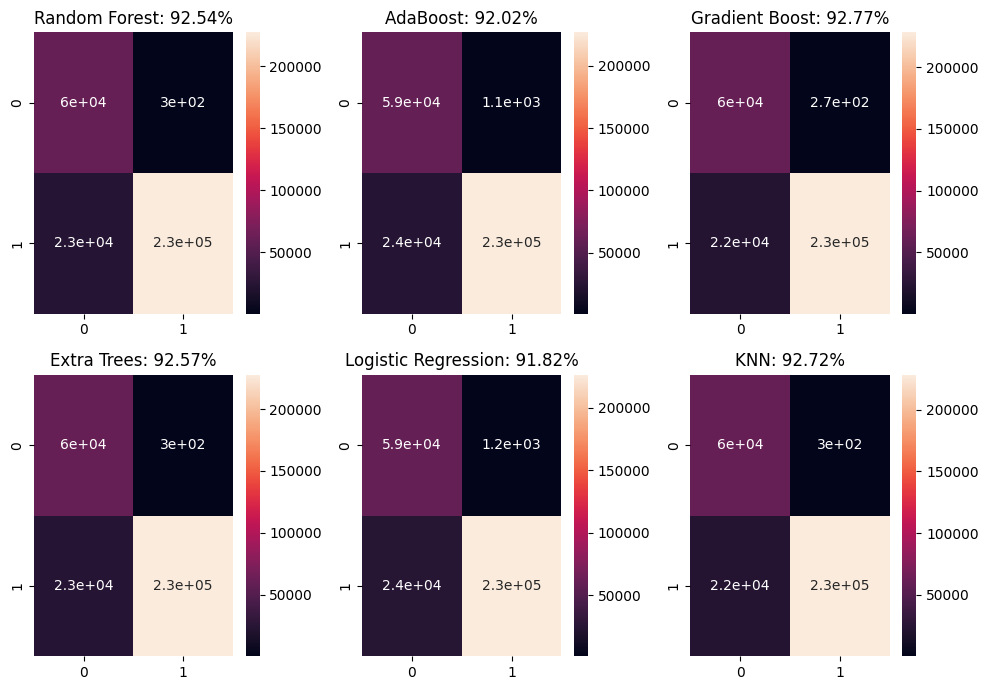

<ipython-input-8-c490f2783530>:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


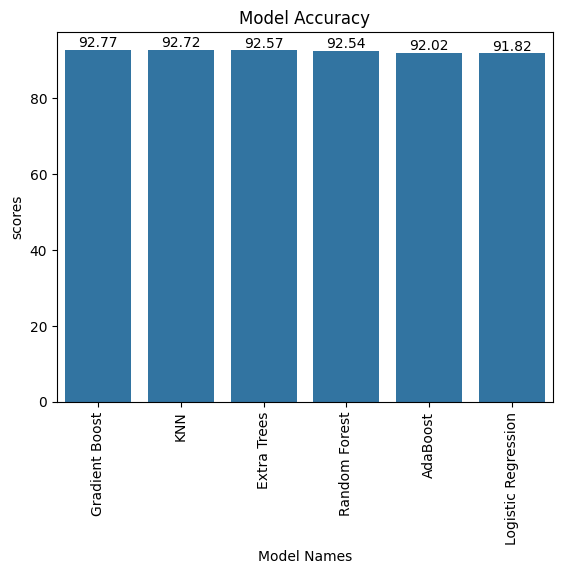

******************************
Gradient Boost
              precision    recall  f1-score   support

           0       0.73      1.00      0.84     60593
           1       1.00      0.91      0.95    250436

    accuracy                           0.93    311029
   macro avg       0.86      0.95      0.90    311029
weighted avg       0.95      0.93      0.93    311029




******************************
KNN
              precision    recall  f1-score   support

           0       0.73      1.00      0.84     60593
           1       1.00      0.91      0.95    250436

    accuracy                           0.93    311029
   macro avg       0.86      0.95      0.90    311029
weighted avg       0.95      0.93      0.93    311029




******************************
Extra Trees
              precision    recall  f1-score   support

           0       0.73      0.99      0.84     60593
           1       1.00      0.91      0.95    250436

    accuracy                           0.93    31102

In [ ]:
predicting_anomaly(X_train_ml, X_test_ml, y_train_ml, y_test_ml, models, model_names)

embeddings + pca + numeric encoding results

Row Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Random Forest
Current Model:  AdaBoost
Current Model:  Gradient Boost


Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Extra Trees
Current Model:  Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Current Model:  KNN


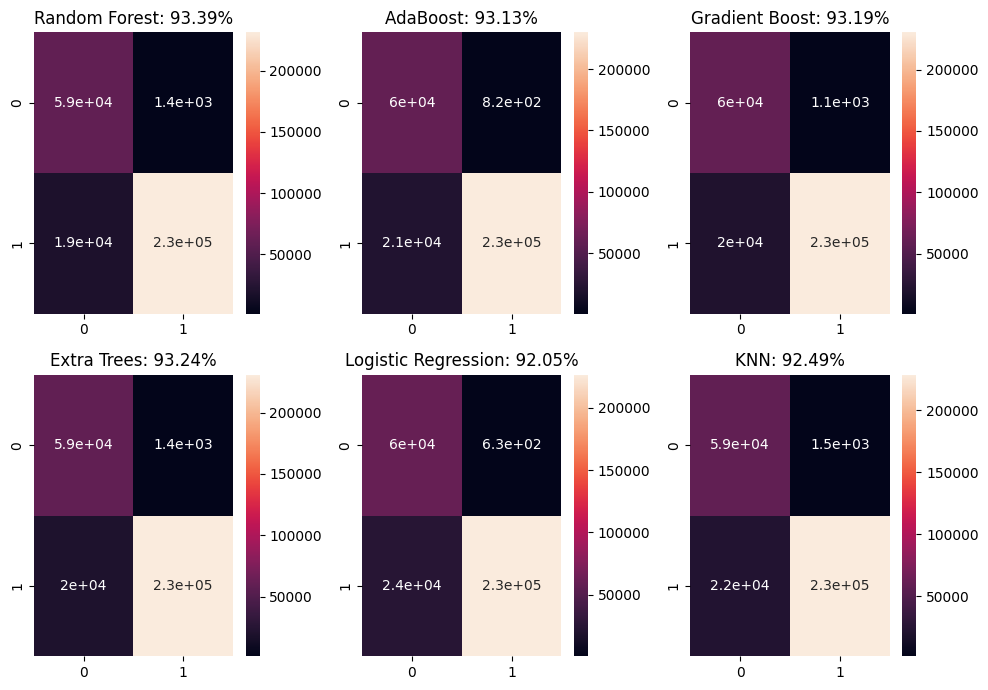

<ipython-input-12-c490f2783530>:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


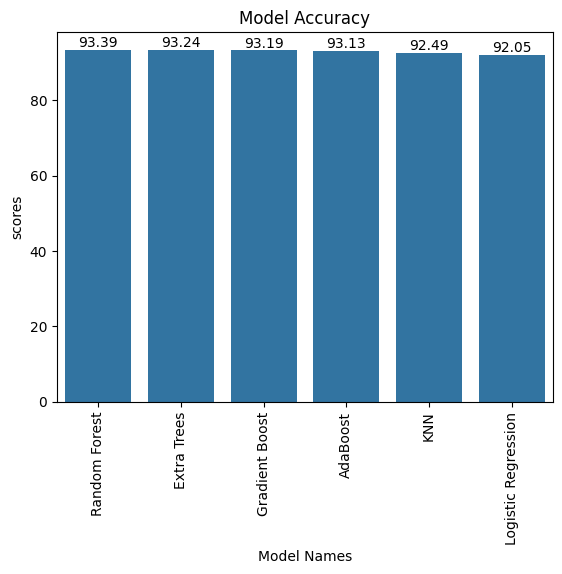

******************************
Random Forest
              precision    recall  f1-score   support

           0       0.76      0.98      0.85     60593
           1       0.99      0.92      0.96    250436

    accuracy                           0.93    311029
   macro avg       0.87      0.95      0.90    311029
weighted avg       0.95      0.93      0.94    311029




******************************
Extra Trees
              precision    recall  f1-score   support

           0       0.75      0.98      0.85     60593
           1       0.99      0.92      0.96    250436

    accuracy                           0.93    311029
   macro avg       0.87      0.95      0.90    311029
weighted avg       0.95      0.93      0.94    311029




******************************
Gradient Boost
              precision    recall  f1-score   support

           0       0.75      0.98      0.85     60593
           1       1.00      0.92      0.96    250436

    accuracy                           0.9

In [ ]:
predicting_anomaly(embeddings_train_pca, embeddings_test_pca, y_train_ml, y_test_ml, models, model_names)

embeddings + pca

Row Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Random Forest
Current Model:  AdaBoost
Current Model:  Gradient Boost


Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Extra Trees
Current Model:  Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Current Model:  KNN


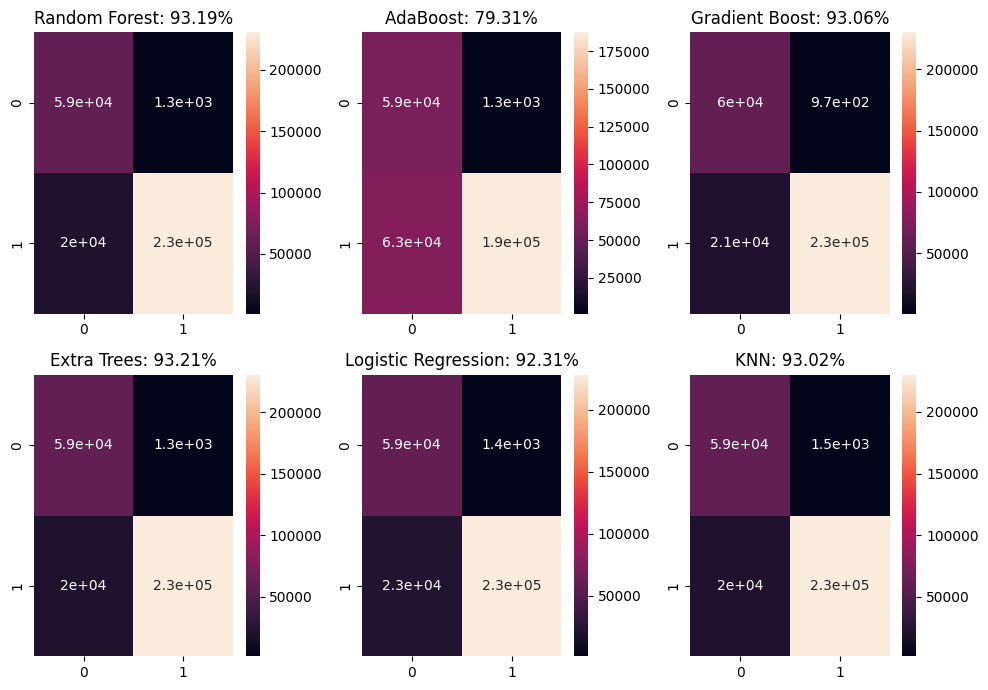

<ipython-input-11-c490f2783530>:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


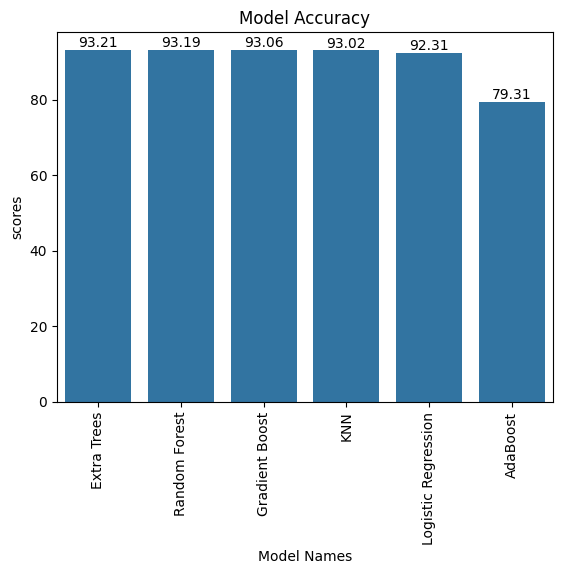

******************************
Extra Trees
              precision    recall  f1-score   support

           0       0.75      0.98      0.85     60593
           1       0.99      0.92      0.96    250436

    accuracy                           0.93    311029
   macro avg       0.87      0.95      0.90    311029
weighted avg       0.95      0.93      0.94    311029




******************************
Random Forest
              precision    recall  f1-score   support

           0       0.75      0.98      0.85     60593
           1       0.99      0.92      0.96    250436

    accuracy                           0.93    311029
   macro avg       0.87      0.95      0.90    311029
weighted avg       0.95      0.93      0.94    311029




******************************
Gradient Boost
              precision    recall  f1-score   support

           0       0.74      0.98      0.85     60593
           1       1.00      0.92      0.96    250436

    accuracy                           0.9

In [ ]:
predicting_anomaly(embeddings_train_pca, embeddings_test_pca, y_train_ml, y_test_ml, models, model_names)

Row Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Random Forest
Current Model:  AdaBoost
Current Model:  Gradient Boost


Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Extra Trees
Current Model:  Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Current Model:  KNN


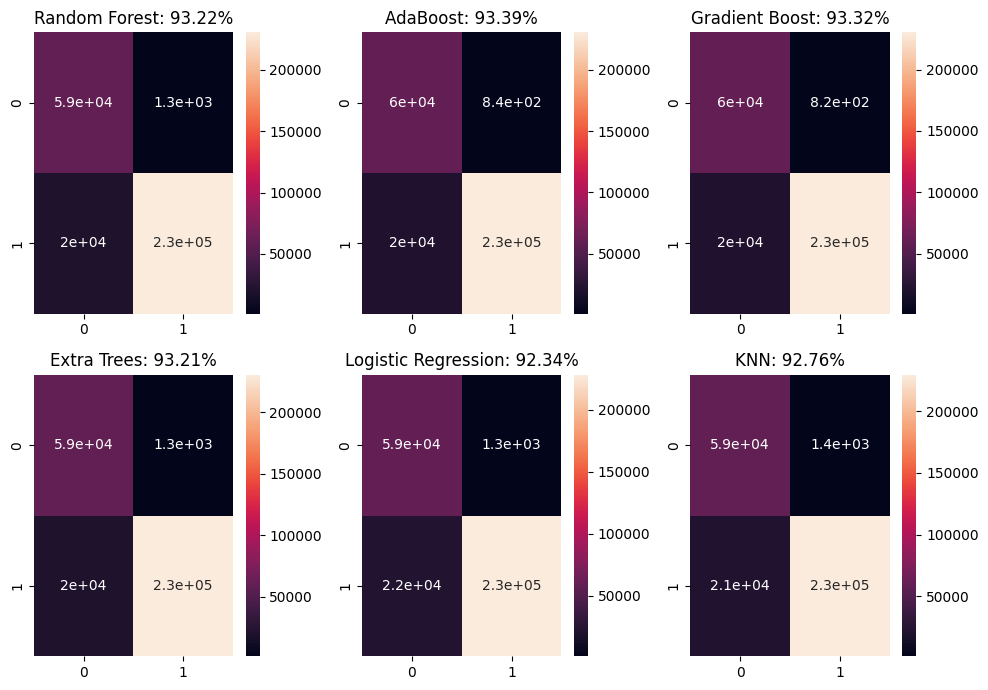

<ipython-input-10-c490f2783530>:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


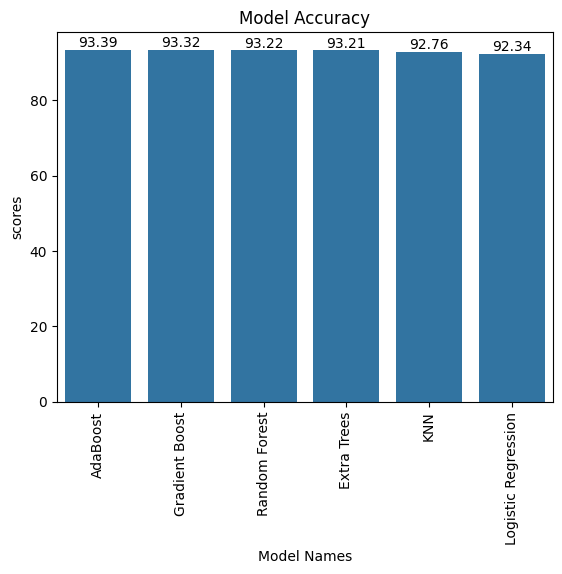

******************************
AdaBoost
              precision    recall  f1-score   support

           0       0.75      0.99      0.85     60593
           1       1.00      0.92      0.96    250436

    accuracy                           0.93    311029
   macro avg       0.87      0.95      0.91    311029
weighted avg       0.95      0.93      0.94    311029




******************************
Gradient Boost
              precision    recall  f1-score   support

           0       0.75      0.99      0.85     60593
           1       1.00      0.92      0.96    250436

    accuracy                           0.93    311029
   macro avg       0.87      0.95      0.90    311029
weighted avg       0.95      0.93      0.94    311029




******************************
Random Forest
              precision    recall  f1-score   support

           0       0.75      0.98      0.85     60593
           1       0.99      0.92      0.96    250436

    accuracy                           0.93  

In [ ]:
predicting_anomaly(embeddings_train, embeddings_test, y_train_ml, y_test_ml, models, model_names)

misc

## Results with LLM Embeddings

Row Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Random Forest
Current Model:  AdaBoost
Current Model:  Gradient Boost


Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Extra Trees
Current Model:  SVC
Current Model:  XGBoost


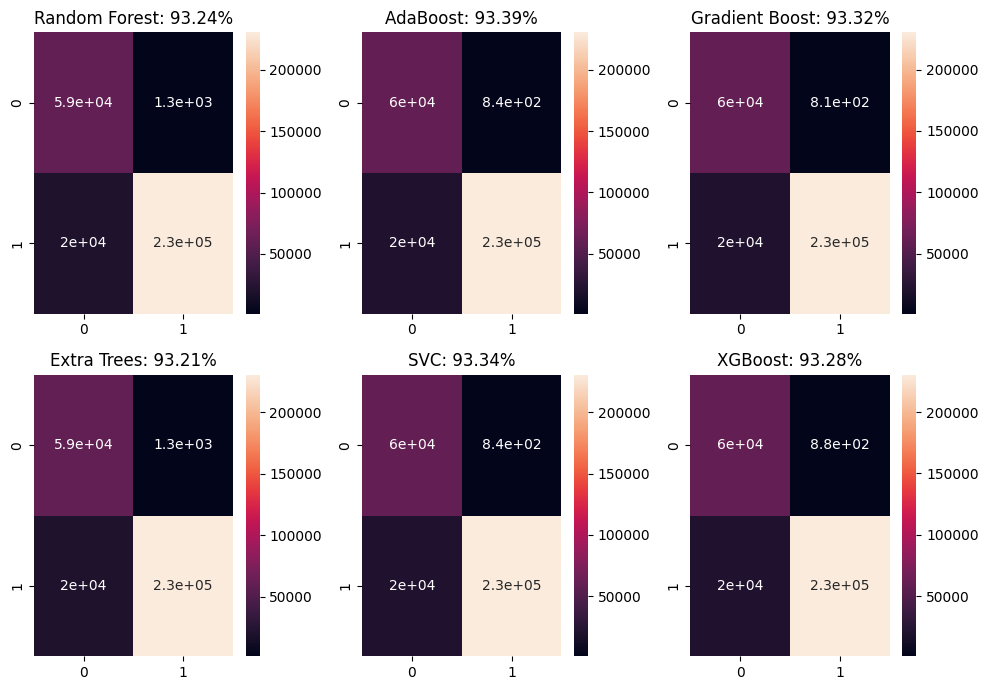

<ipython-input-14-a42bbc12bd5e>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


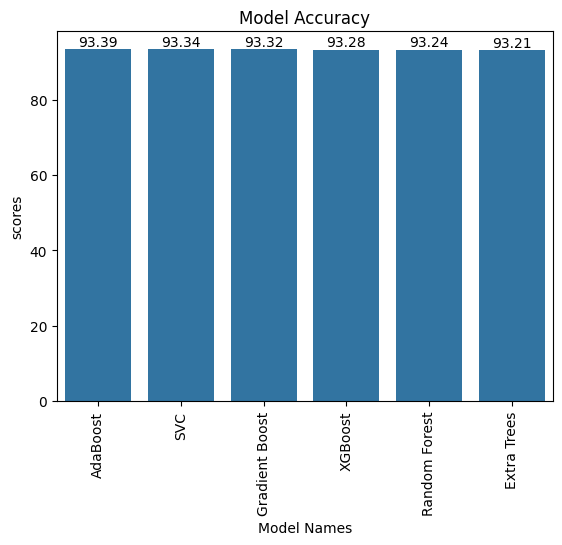

******************************
AdaBoost
              precision    recall  f1-score   support

           0       0.75      0.99      0.85     60593
           1       1.00      0.92      0.96    250436

    accuracy                           0.93    311029
   macro avg       0.87      0.95      0.91    311029
weighted avg       0.95      0.93      0.94    311029




******************************
SVC
              precision    recall  f1-score   support

           0       0.75      0.99      0.85     60593
           1       1.00      0.92      0.96    250436

    accuracy                           0.93    311029
   macro avg       0.87      0.95      0.90    311029
weighted avg       0.95      0.93      0.94    311029




******************************
Gradient Boost
              precision    recall  f1-score   support

           0       0.75      0.99      0.85     60593
           1       1.00      0.92      0.96    250436

    accuracy                           0.93    311029
 

In [ ]:
predicting_anomaly(embeddings_train, embeddings_test, y_train_ml, y_test_ml, models, model_names)

Row Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Random Forest
Current Model:  AdaBoost
Current Model:  Gradient Boost


Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Extra Trees
Current Model:  SVC
Current Model:  XGBoost


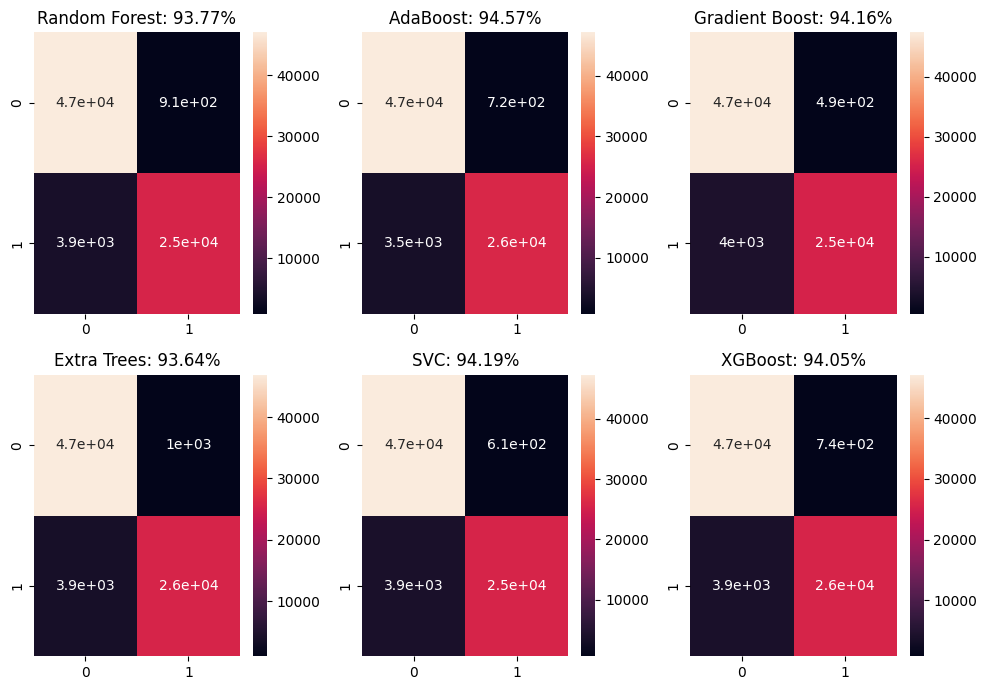

<ipython-input-11-a42bbc12bd5e>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


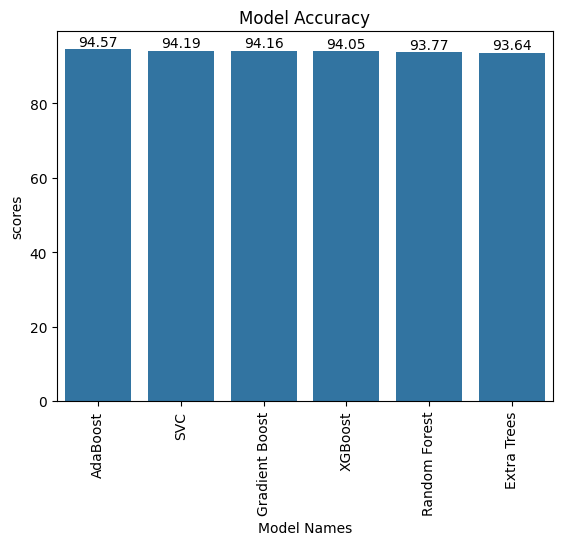

******************************
AdaBoost
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     47913
           1       0.97      0.88      0.93     29373

    accuracy                           0.95     77286
   macro avg       0.95      0.93      0.94     77286
weighted avg       0.95      0.95      0.95     77286




******************************
SVC
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     47913
           1       0.98      0.87      0.92     29373

    accuracy                           0.94     77286
   macro avg       0.95      0.93      0.94     77286
weighted avg       0.94      0.94      0.94     77286




******************************
Gradient Boost
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     47913
           1       0.98      0.86      0.92     29373

    accuracy                           0.94     77286
 

In [ ]:
predicting_anomaly(embeddings_train, embeddings_test, y_train_ml, y_test_ml, models, model_names)

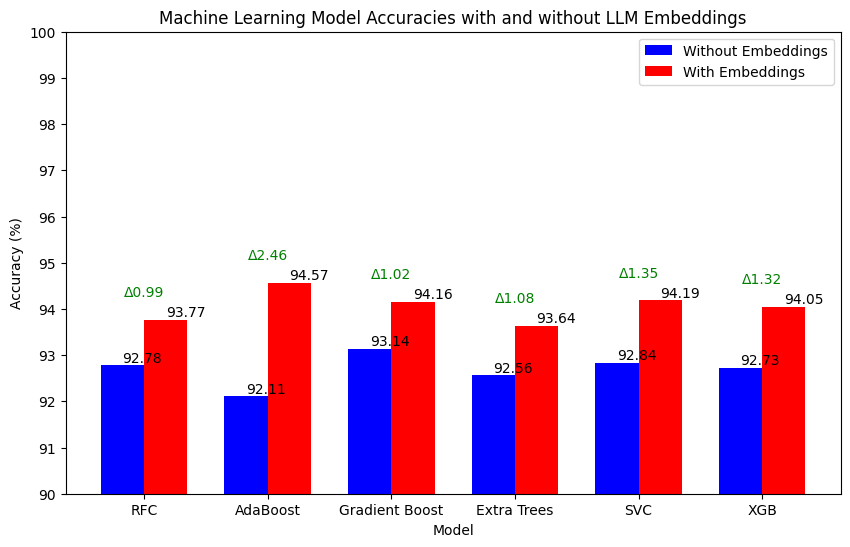

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['RFC', 'AdaBoost', 'Gradient Boost', 'Extra Trees', 'SVC', 'XGB']
without_embeddings = [92.78, 92.11, 93.14, 92.56, 92.84, 92.73]
with_embeddings = [93.77, 94.57, 94.16, 93.64, 94.19, 94.05]
accuracy_change = np.subtract(with_embeddings, without_embeddings)  # Calculate change in accuracy

# Plot configuration
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart
bar_width = 0.35
index = np.arange(len(models))

bars1 = ax.bar(index, without_embeddings, bar_width, label='Without Embeddings', color='b')
bars2 = ax.bar(index + bar_width, with_embeddings, bar_width, label='With Embeddings', color='r')

# Displaying exact accuracy scores and changes on the chart
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom')  # Va: vertical alignment

for i, change in enumerate(accuracy_change):
    ax.text(i + bar_width/2, with_embeddings[i] + 0.5, f'Δ{change:.2f}', ha='center', color='green')

# Adjusting Y-axis limits and ticks
ax.set_ylim(90, 100)  # Set the new y-axis limits
ax.set_yticks(np.arange(90, 101, 1))  # Detailed steps from 90.0 to 100.0

# Formatting
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Machine Learning Model Accuracies with and without LLM Embeddings')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
ax.legend()

plt.show()


## Results for Numeric encoded LLM embeddings

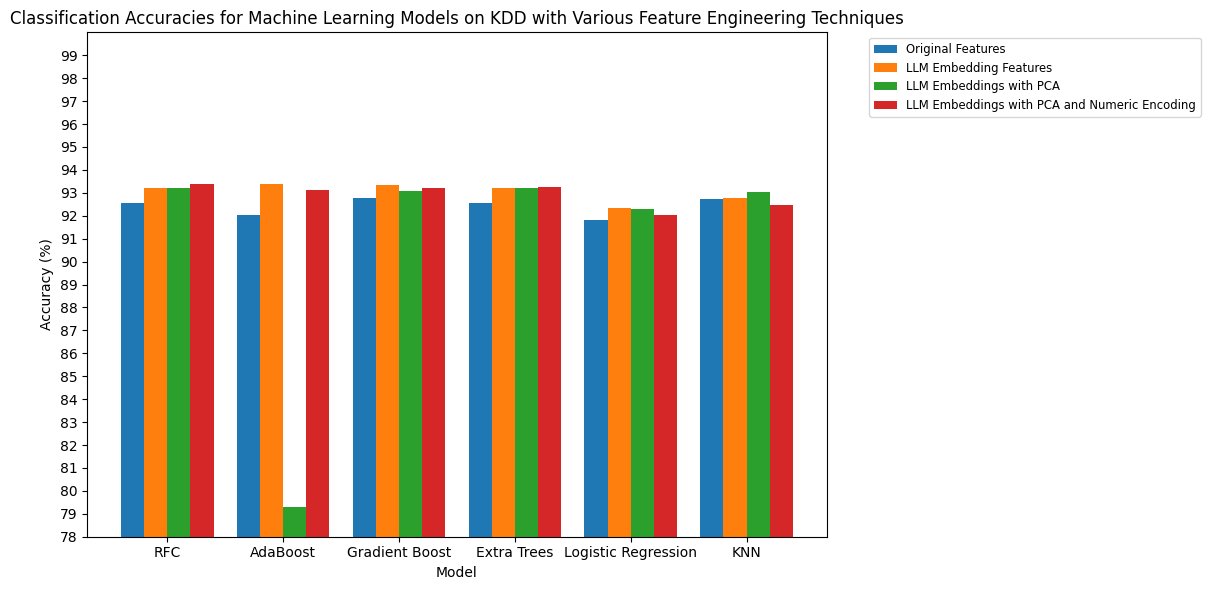

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['RFC', 'AdaBoost', 'Gradient Boost', 'Extra Trees', 'Logistic Regression', 'KNN']
without_embeddings = [92.54, 92.02, 92.77, 92.57, 91.82, 92.72]
with_embeddings = [93.22, 93.39, 93.32, 93.21, 92.34, 92.76]
with_embeddings_pca = [93.19, 79.31, 93.06, 93.21, 92.31, 93.02]
with_encode_embeddings_pca = [93.39, 93.13, 93.19, 93.24, 92.05, 92.49]

# Plot configuration
fig, ax = plt.subplots(figsize=(12, 6))

# Bar chart
bar_width = 0.2
index = np.arange(len(models))

bars1 = ax.bar(index, without_embeddings, bar_width, label='Original Features')
bars2 = ax.bar(index + bar_width, with_embeddings, bar_width, label='LLM Embedding Features')
bars3 = ax.bar(index + 2 * bar_width, with_embeddings_pca, bar_width, label='LLM Embeddings with PCA')
bars4 = ax.bar(index + 3 * bar_width, with_encode_embeddings_pca, bar_width, label='LLM Embeddings with PCA and Numeric Encoding')


# Adjusting Y-axis limits and ticks
ax.set_ylim(78, 100)  # Extended Y-axis to give more space above and below the bars
ax.set_yticks(np.arange(78, 100, 1))  # Adjust y-tick intervals

# Formatting
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Classification Accuracies for Machine Learning Models on KDD with Various Feature Engineering Techniques')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(models)
ax.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


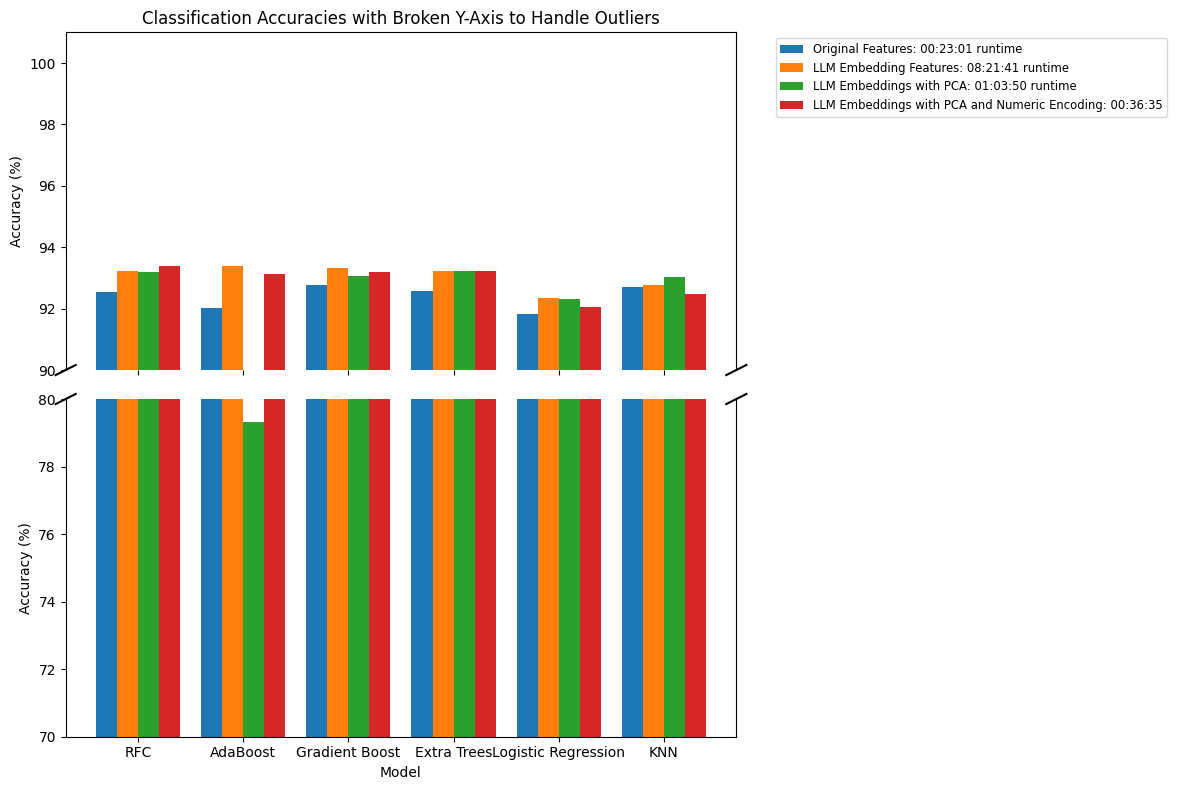

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['RFC', 'AdaBoost', 'Gradient Boost', 'Extra Trees', 'Logistic Regression', 'KNN']
without_embeddings = [92.54, 92.02, 92.77, 92.57, 91.82, 92.72]
with_embeddings = [93.22, 93.39, 93.32, 93.21, 92.34, 92.76]
with_embeddings_pca = [93.19, 79.31, 93.06, 93.21, 92.31, 93.02]
with_encode_embeddings_pca = [93.39, 93.13, 93.19, 93.24, 92.05, 92.49]

# Plot configuration
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

bar_width = 0.2
index = np.arange(len(models))

# Plot the same bars in both axes
bars1 = ax.bar(index, without_embeddings, bar_width, label='Original Features: 00:23:01 runtime')
bars2 = ax.bar(index + bar_width, with_embeddings, bar_width, label='LLM Embedding Features: 08:21:41 runtime')
bars3 = ax.bar(index + 2 * bar_width, with_embeddings_pca, bar_width, label='LLM Embeddings with PCA: 01:03:50 runtime')
bars4 = ax.bar(index + 3 * bar_width, with_encode_embeddings_pca, bar_width, label='LLM Embeddings with PCA and Numeric Encoding: 00:36:35')

# Same bars for the second plot
ax2.bar(index, without_embeddings, bar_width)
ax2.bar(index + bar_width, with_embeddings, bar_width)
ax2.bar(index + 2 * bar_width, with_embeddings_pca, bar_width)
ax2.bar(index + 3 * bar_width, with_encode_embeddings_pca, bar_width)

# Set the y-limits for the zoomed-in portion
ax.set_ylim(90, 101)  # Top plot showing the important range
ax2.set_ylim(70, 80)  # Bottom plot showing the outlier

# Break marks
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.tick_params(labeltop=False)  # Don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Diagonal lines for the break
d = 0.015  # How big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)  # Top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

kwargs.update(transform=ax2.transAxes)  # Switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

# Formatting
ax2.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax2.set_ylabel('Accuracy (%)')
ax.set_title('Classification Accuracies with Broken Y-Axis to Handle Outliers')
ax2.set_xticks(index + 1.5 * bar_width)
ax2.set_xticklabels(models)
ax.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
